# XGBoost

In [1]:
# Bloc non affiché

import numpy as np
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, confusion_matrix,accuracy_score, matthews_corrcoef, make_scorer


from xgboost import XGBClassifier
from xgboost import plot_importance


from sklearn.model_selection import GridSearchCV



def result_model(model,X,Y) :
    Y_model =model.predict(X)

    f1_scor = f1_score(Y,Y_model)
    print('Le f1 score vaut',f1_scor)
    
#     score = cross_val_score(model,X,Y,cv=5,scoring = make_scorer(f1_score))
#     print('F1 cross validé :', np.mean(score))
    
   # Matrice de confusion
    cm_model = confusion_matrix(Y, Y_model)
    plt.rcParams['figure.figsize'] = (5, 5)
    sns.heatmap(cm_model, annot = True)
    plt.title(str(model))
    plt.show()
    
    return(f1_scor)

## Téléchargement des données

In [2]:
train = pd.read_csv("https://www.data.mclavier.com/prj_datascience/train_v1.csv")

## Pre-processing

On sépare dans un premier temps les variables explicatives et la variable à expliquer.

In [3]:
# Décomposition features / target
X = train.drop(columns='Response')
Y = train['Response']

Ensuite, on décompose en bdd train et test puis on scale les données grâce à sklearn.

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,train_size = 0.9)

scaler=StandardScaler() 

X_scal_train = scaler.fit_transform(X_train)
X_scal_test = scaler.transform(X_test) 

X_scal_train = pd.DataFrame(X_scal_train,index= X_train.index, columns=X.columns)
X_scal_test = pd.DataFrame(X_scal_test,index= X_test.index, columns=X.columns)

Le modèle final sera entrainé sur l'intégralité de la base que nous possédons. Mais actuellement, nous souhaitons mesure le caractère prédictif de nos données et donc pour éviter l'overfitting, nous séparons tout de même nos données.

## Modèle

In [20]:
xgb0 = XGBClassifier(use_label_encoder=False)
xgb0.fit(X_train, Y_train)

[11:11:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

Le f1 score vaut 0.3964879852125693


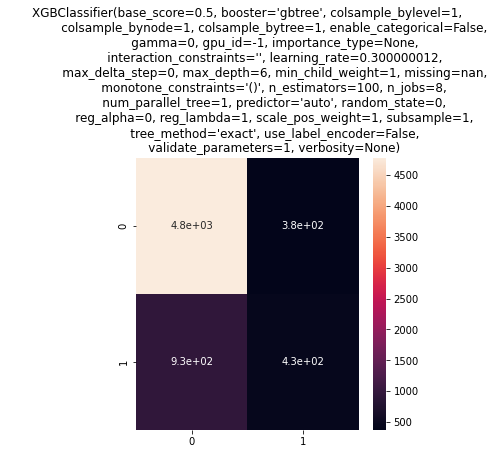

In [21]:
f1 = result_model(xgb0, X_test, Y_test)

## Tuning

Pour tuner le programme, on s'inspire grandement de [ce site](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/#h2_9).

In [36]:
#Import libraries:
import numpy as np
import pandas as pd

import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV   #Perforing grid search

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

In [37]:
target = 'Response'
predictors = [x for x in train.columns if x not in [target]]



def modelfit(alg, dtrain, predictors, useTrainCV = True, cv_folds=5, early_stopping_rounds=50):

    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])

    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    # dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    print("\nMesures :")
    print("---------")
    print("Accuracy : ", accuracy_score(dtrain[target].values, dtrain_predictions))
    print("f1 : ", f1_score(dtrain[target].values, dtrain_predictions))


    plot_importance(xgb1)
    plt.show()

Dans un premier temps, on récupère les paramètres de bases que l'on va tuner par la suite.

In [38]:
params = xgb0.get_xgb_params()

On modifie quelques paramètres de base au regard des TP réalisés.

In [39]:
params['seed'] = 27
params['nthread'] = 7
params["use_label_encoder"] = False
params["n_estimators"] = 1000


Mesures :
---------
Accuracy :  0.809403849403235
f1 :  0.3475654642969818


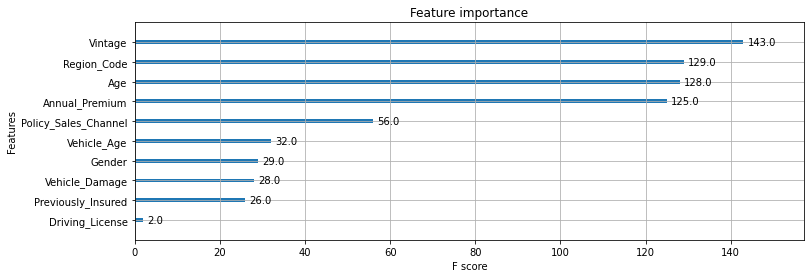

In [40]:
xgb1 = XGBClassifier(**params)

modelfit(xgb1, train, predictors)

### Etape 2

Lors du tuning, nous diminuons le nombre d'estimators pour réduire le temps de calcul

In [41]:
params["n_estimators"] = 140

On tune max_depth et min_child_weight

In [42]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6)
}

In [43]:
gsearch1 = GridSearchCV(
    estimator = XGBClassifier(**params),
    param_grid = param_test1, scoring='f1', n_jobs=4, cv=5)
 
gsearch1.fit(train[predictors],train[target])

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1,
                                     enable_categorical=False, gamma=0,
                                     gpu_id=-1, importance_type=None,
                                     interaction_constraints='',
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=6,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='()',
                                     n_estimators=140, n_jobs=8, nthread=7,
                                     num_parallel_tree=1, predictor='auto',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=27, subs

In [44]:
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 9, 'min_child_weight': 5}, 0.4024780585914988)

Nous pouvons modifier *min_child_weight* dans les paramètres.

In [46]:
params["max_depth"] = 9
params["min_child_weight"] = 5

Étant à la limite sur les deux paramètres, nous testons avec des paramètres plus forts.

In [48]:
param_test2 = {
'max_depth':[9, 20,45, 50, 75],
'min_child_weight':[5, 10, 20]
}

gsearch2 = GridSearchCV(
                estimator = XGBClassifier(**params),
                param_grid = param_test2, scoring='f1',n_jobs=4,cv=5)

gsearch2.fit(train[predictors],train[target])

In [ ]:
gsearch2.best_params_, gsearch2.best_score_

Si on est à une valeur optimale on peut tester plus haut

In [57]:
param_test2b = {
    'max_depth':[10, 12, 14],
    'min_child_weight':[4,6,8]
}

gsearch2b = GridSearchCV(
                estimator = XGBClassifier(use_label_encoder=False,
                                learning_rate=0.1, n_estimators=140, max_depth=10,
                                min_child_weight=4, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                param_grid = param_test2b, scoring='f1',n_jobs=4, cv=5)

gsearch2b.fit(train[predictors],train[target])
gsearch2b.best_params_, gsearch2b.best_score_

C:\Users\mathi\.virtualenvs\ISFA-prj-datascience-4Z2Vzt1R\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:23:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


({'max_depth': 14, 'min_child_weight': 4}, 0.3993741715926763)

In [60]:
param_test2c = {
   'max_depth':[14, 40, 50, 60]
}

gsearch2c = GridSearchCV(
               estimator = XGBClassifier(use_label_encoder=False,
                              learning_rate=0.1, n_estimators=140, max_depth=14,
                              min_child_weight=4, gamma=0, subsample=0.8, colsample_bytree=0.8,
                              objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
               param_grid = param_test2c, scoring='f1',n_jobs=4, cv=5)

gsearch2c.fit(train[predictors],train[target])
gsearch2c.best_params_, gsearch2c.best_score_

C:\Users\mathi\.virtualenvs\ISFA-prj-datascience-4Z2Vzt1R\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:35:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


({'max_depth': 300}, 0.4070579630517889)

In [43]:
param_test2d = {
    'max_depth':[9, 30, 40, 45, 50]
}

gsearch2d = GridSearchCV(
                estimator = XGBClassifier(use_label_encoder=False,
                                learning_rate=0.1, n_estimators=140, max_depth=50,
                                min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                objective= 'binary:logistic', nthread=7, scale_pos_weight=1,seed=27), 
                param_grid = param_test2d, scoring='f1',n_jobs=4, cv=5)
                
gsearch2d.fit(train[predictors],train[target])


[08:59:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8,
                                     enable_categorical=False, gamma=0,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=50, min_child_weight=3,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=140, n_jobs=None, nthread=7,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weigh

In [45]:
gsearch2d.best_params_, gsearch2d.best_score_

({'max_depth': 45}, 0.4079003239560688)

### Etape 3 : Gamma

Now lets tune gamma value using the parameters already tuned above. Gamma can take various values but I’ll check for 5 values here. You can go into more precise values as.

In [46]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}

In [47]:
gsearch3 = GridSearchCV(estimator = XGBClassifier(use_label_encoder=False,
                                    learning_rate =0.1, n_estimators=140, max_depth=45,
                                    min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                    objective= 'binary:logistic', nthread=7, scale_pos_weight=1,seed=27), 
                        param_grid = param_test3, scoring='f1',n_jobs=4, cv=5)

gsearch3.fit(train[predictors],train[target])

C:\Users\mathi\.virtualenvs\ISFA-prj-datascience-4Z2Vzt1R\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:11:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8,
                                     enable_categorical=False, gamma=0,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=45, min_child_weight=3,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=140, n_jobs=None, nthread=7,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weigh

In [49]:
gsearch3.best_params_, gsearch3.best_score_

({'gamma': 0.3}, 0.4084335511553004)

This shows that our original value of gamma, i.e. 0 is the optimum one. Before proceeding, a good idea would be to re-calibrate the number of boosting rounds for the updated parameters.

In [53]:
xgb2 = XGBClassifier(
        use_label_encoder=False,
        learning_rate =0.1,
        n_estimators=1000,
        max_depth=45,
        min_child_weight=3,
        gamma=0.3,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=7,
        scale_pos_weight=1,
        seed=27
        )


Mesures :
---------
Accuracy :  0.8901092149122133
f1 :  0.6765822784810126


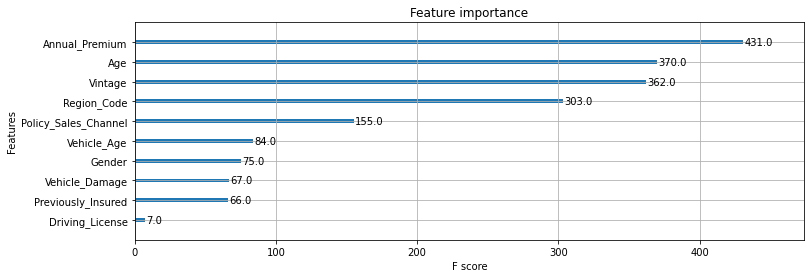

In [54]:
modelfit(xgb2, train, predictors)

### Etape 4 : Tune subsample et colsample_bytree

In [55]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

In [56]:
gsearch4 = GridSearchCV(
    estimator = XGBClassifier(use_label_encoder=False,
                learning_rate =0.1, n_estimators=177, max_depth=45,
                min_child_weight=4, gamma=0.3, subsample=0.8, colsample_bytree=0.8,
                objective= 'binary:logistic', nthread=7, scale_pos_weight=1,seed=27), 
    param_grid = param_test4, scoring='f1',n_jobs=4, cv=5)
gsearch4.fit(train[predictors],train[target])

KeyboardInterrupt: 

In [ ]:
gsearch4.best_params_, gsearch4.best_score_

Here, we found 0.8 as the optimum value for both subsample and colsample_bytree. Now we should try values in 0.05 interval around these.

In [78]:
param_test5 = {
 'subsample':[i/100.0 for i in range(75,90,5)],
 'colsample_bytree':[i/100.0 for i in range(85,100,5)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=50,
                             min_child_weight=4, gamma=0, subsample=0.8, colsample_bytree=0.9,
                            objective= 'binary:logistic', nthread=7, scale_pos_weight=1,seed=27), 
            param_grid = param_test5, scoring='f1',n_jobs=4, cv=5)
gsearch5.fit(train[predictors],train[target])
gsearch5.best_params_, gsearch5.best_score_

C:\Users\mathi\.virtualenvs\ISFA-prj-datascience-4Z2Vzt1R\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:19:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


({'colsample_bytree': 0.9, 'subsample': 0.8}, 0.4117609417997697)

### Step 5: Tuning Regularization Parameters

Next step is to apply regularization to reduce overfitting. Though many people don’t use this parameters much as gamma provides a substantial way of controlling complexity. But we should always try it. I’ll tune ‘reg_alpha’ value here and leave it upto you to try different values of ‘reg_lambda’.

In [79]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=50,
                                 min_child_weight=4, gamma=0.1, subsample=0.8, colsample_bytree=0.9,
                                 objective= 'binary:logistic', nthread=7, scale_pos_weight=1,seed=27), 
                        param_grid = param_test6, scoring='f1',n_jobs=4, cv=5)
gsearch6.fit(train[predictors],train[target])
gsearch6.best_params_, gsearch6.best_score_

C:\Users\mathi\.virtualenvs\ISFA-prj-datascience-4Z2Vzt1R\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:28:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


({'reg_alpha': 1e-05}, 0.41076480565646045)

In [84]:
xgb3 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=50,
 min_child_weight=4,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.9,
 reg_alpha=1e-5,
 objective= 'binary:logistic',
 nthread=7,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb3, train, predictors)

C:\Users\mathi\.virtualenvs\ISFA-prj-datascience-4Z2Vzt1R\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Model Report
Accuracy :  0.883719144099169
f1 :  0.6570936763906505


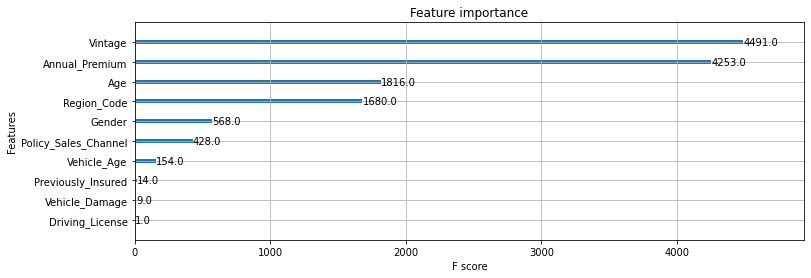

In [85]:
plot_importance(xgb3)
plt.show()

### Etape 6 : Learning rate

Lastly, we should lower the learning rate and add more trees. Lets use the cv function of XGBoost to do the job again.

In [86]:
xgb4 = XGBClassifier(
 learning_rate =0.01,
 n_estimators=5000,
 max_depth=50,
 min_child_weight=4,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.9,
 reg_alpha=1e-5,
 objective= 'binary:logistic',
 nthread=7,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb4, train, predictors)

C:\Users\mathi\.virtualenvs\ISFA-prj-datascience-4Z2Vzt1R\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Model Report
Accuracy :  0.8726133239120751
f1 :  0.6059396531242576


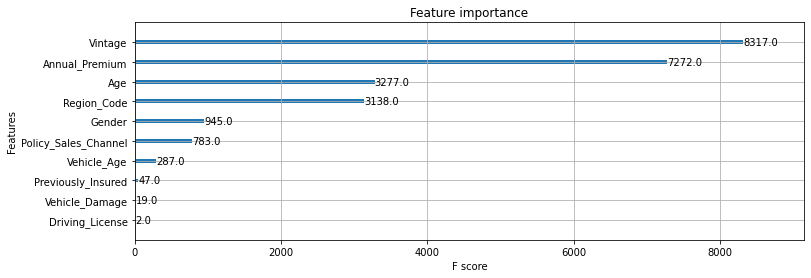

In [87]:
plot_importance(xgb4)
plt.show()

In [80]:
params = {
    # "learning_rate": 0.003,
    # "max_depth": 5,
    # "eta":0.01, 
    # "nfold":5,
    # "nrounds":716
}

In [37]:
gsearch1.grid_scores_

AttributeError: 'GridSearchCV' object has no attribute 'grid_scores_'

In [ ]:
params = {
    # "learning_rate": 0.003,
    # "max_depth": 5,
    # "eta":0.01, 
    # "nfold":5,
    # "nrounds":716
}

In [ ]:
xgb = XGBClassifier(**params)
xgb.fit(X_train, Y_train)

Puis, nous pouvons directement entrainer le modèle et l'afficher grâce à notre fonction *result_model*.

Le F1-score n'est pas satisfaisant ce qui est évident au regard de la matrice de confusion. Tout est prédit en positif.

<br><br><br><br>